In [1]:
import training.networks_encoder as networks_encoder
import torch
import numpy as np
import torchvision

pSp_encoder = networks_encoder.Encoder
pretrained_pkl = "/root/data/stylegan3/inver_GazeCapture/00012-base-train-gpus1-batch12/network_snapshots/network-snapshot-100000.pkl"
E = pSp_encoder(
    pretrained=pretrained_pkl,
    w_avg=None,
)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
E = E.to(device).eval()

(-0.5, 127.5, 127.5, -0.5)

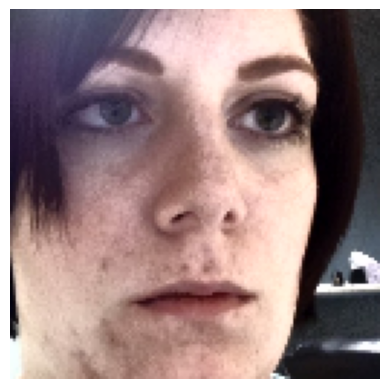

In [2]:
# Load image
import os
from PIL import Image
import matplotlib.pyplot as plt

img_path = "/root/data/dataset_prep/GazeCapture/train"
img_lst = sorted(os.listdir(img_path))
img_lst = [os.path.join(img_path, x) for x in img_lst]

img = Image.open(img_lst[0])
plt.imshow(img)
plt.axis('off')

In [3]:
# load dataset class from encoder
import training.dataset_encoder as dataset_encoder
from torch.utils.data import DataLoader

# dataset = dataset_encoder.ImagesDataset(
#     dataset_dir=img_path,
#     mode='inference'
# )
# dataloader = DataLoader(
#     dataset=dataset,
#     batch_size=5,
#     shuffle=False,
#     num_workers=3,
#     drop_last=False
# )

# test_batch = next(iter(dataloader))[0] # X
# print(test_batch.shape)
# test_batch = test_batch.to(device)

test_latent_batch = E(test_batch)

NameError: name 'test_batch' is not defined

In [1]:
# directly from gazecapture
import dataset
gazeCaptureDataset = dataset.HDFDataset(
    hdf_file_path='/root/data/dataset_prep/faze_preprocess/outputs_sted/GazeCapture.h5'
)
print(f"Number of samples: {len(gazeCaptureDataset)}")
gazeCaptureDataLoader = DataLoader(
    dataset=gazeCaptureDataset,
    batch_size=5,
    shuffle=True,
    num_workers=3,
    drop_last=False
)
test_batch = next(iter(gazeCaptureDataLoader))
test_batch = test_batch['image_a']

Number of samples: 1634443


NameError: name 'DataLoader' is not defined

In [18]:
import tqdm
from torchvision import transforms
t_128 = transforms.Compose([
    transforms.Resize((256, 256), antialias=True),
    #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

mean_latent = None
channel_mean = None
channel_mean_squared = None
total_samples = 0
with torch.no_grad():
    for i, batch in tqdm.tqdm(enumerate(gazeCaptureDataLoader)):
        test_batch = batch['image_a']
        test_batch = t_128(test_batch) 
        test_batch = test_batch.to(device)
        test_latent_batch = E(test_batch) # (batch_size, 16, 512)
        n_samples = test_batch.shape[0]
        total_samples += n_samples
        if mean_latent is None:
            mean_latent = test_latent_batch.mean(dim=0) # (16, 512)
            channel_mean = test_latent_batch.mean(dim=0).mean(dim=0) # (512,)
            assert len(channel_mean) == 512
            channel_mean_squared = (test_latent_batch ** 2).mean(dim=0).mean(dim=0)
        else:
            mean_latent_old = mean_latent.clone()
            channel_mean_old = channel_mean.clone()
            channel_mean_squared_old = channel_mean_squared.clone()

            mean_latent = (mean_latent_old * (total_samples - n_samples) + test_latent_batch.mean(dim=0) * n_samples) / total_samples
            channel_mean = (channel_mean_old * (total_samples - n_samples) + test_latent_batch.mean(dim=0).mean(dim=0) * n_samples) / total_samples
            channel_mean_squared = (channel_mean_squared_old * (total_samples - n_samples) + (test_latent_batch ** 2).mean(dim=0).mean(dim=0) * n_samples) / total_samples
        if i > 1000: break

1001it [00:20, 48.28it/s]


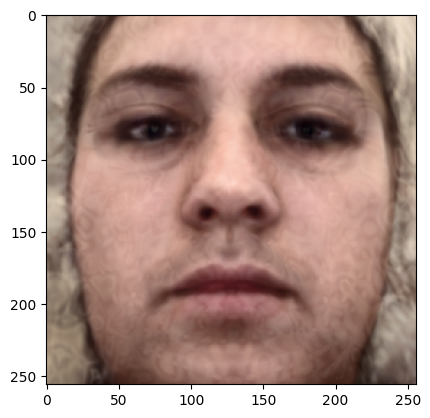

In [19]:
# load generator
import dnnlib # nvidia dnn library
import legacy # legacy support for older models
import PIL
def return_image(images, gh, gw, H, W):
    np_imgs = []
    for i, image in enumerate(images):
        image = images[i][None,:,:]
        image = (image.permute(0,2,3,1)*127.5+128).clamp(0,255).to(torch.uint8).cpu().numpy()
        np_imgs.append(np.asarray(PIL.Image.fromarray(image[0], 'RGB').resize((H,W),PIL.Image.LANCZOS)))
    np_imgs = np.stack(np_imgs)
    np_imgs = np_imgs.reshape(gh,gw,H,W,3)
    np_imgs = np_imgs.transpose(0,2,1,3,4)
    np_imgs = np_imgs.reshape(gh*H, gw*W, 3)
    #PIL.Image.fromarray(np_imgs, 'RGB').save(save_path)
    return PIL.Image.fromarray(np_imgs, 'RGB')

generator_pkl_path = "/root/data/stylegan3/inversion/stylegan3-encoder/pretrained/stylegan3-r-ffhqu-256x256.pkl"
with dnnlib.util.open_url(generator_pkl_path) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device)

G.eval()

plt.imshow(return_image(G.synthesis(mean_latent.unsqueeze(0)), 1, 1, 256, 256))

In [20]:
channel_std = torch.sqrt(channel_mean_squared - channel_mean ** 2)
channel_std

tensor([  2971.1096,   5193.0713,  21315.2422,   3583.3035,   2839.8850,
          3183.3481,   3664.7017,  30752.3887,  70286.8359,  13070.2959,
          2074.4719,  13691.2227,   2348.2007,  36928.6172,  11756.3506,
         11300.5801,   6679.3813,   4532.3857,   6200.0293,   8862.2314,
          4054.2607,   8365.9404,   5109.0493,  42576.9141,   1953.5934,
         66325.1406,  56420.3516,   4403.1641,   2319.9539,   6495.1284,
        130578.6172,  28529.7266,   6005.4536,   5207.5054,  23094.9980,
         51111.3359, 108093.0312,  62225.1758,   1913.4954,   3070.3940,
         72997.4609,  55466.3477,   4402.8804,  38333.5742,   8025.4087,
          9789.9814,   4649.5684,  14179.8506,   8094.3438,   8324.7451,
          9528.3174,   1494.7855,   4025.2493,  48193.3125,   7738.0962,
          3089.9319,  13513.8926,  87005.9531,   3624.9705,  33539.8984,
          1071.7120,  11508.0068,  43118.3359,  65490.7812,   4326.5527,
         47839.1016,  21397.4629,   7067.7734,  993

In [ ]:
torch.save({
    'mean_latent': mean_latent,
    'channel_mean': channel_mean,
    'channel_std': channel_std
}, '/root/data/project_folder/utils/mean_std.pt')

2023-05-09 00:19:13,660 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


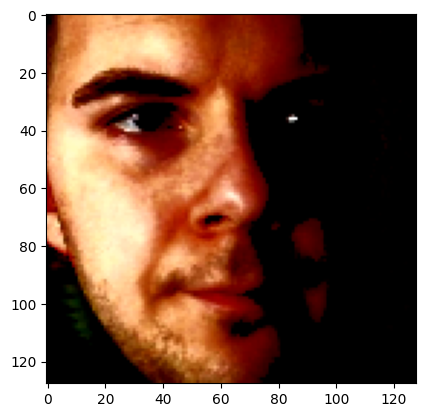

In [5]:
test_batch = next(iter(gazeCaptureDataLoader))
test_batch = test_batch['image_a']
plt.imshow(test_batch[0].permute(1, 2, 0))

torch.Size([5, 3, 256, 256])


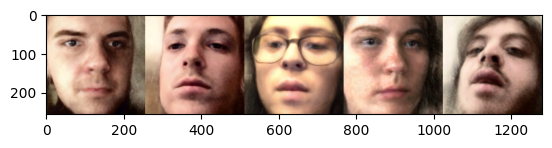

In [8]:
from torchvision import transforms
t_128 = transforms.Compose([
    transforms.Resize((256, 256), antialias=True),
    #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
test_batch_t = t_128(test_batch)
print(test_batch_t.shape)
test_latent_batch = E(test_batch_t.to(device))
out = G.synthesis(test_latent_batch)
plt.imshow(return_image(out, 1, 5, 256, 256))
#plt.imshow(out.permute(0, 2, 3, 1)[0].cpu().detach().numpy())

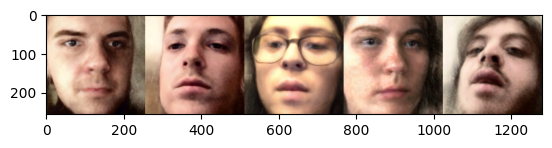

In [10]:
permuted_latent_batch = test_latent_batch.permute(0, 2, 1).view(5, 512, 4 ,4)
restored_latent_batch = permuted_latent_batch.view(5, 512, 16).permute(0, 2, 1)

out = G.synthesis(restored_latent_batch)
plt.imshow(return_image(out, 1, 5, 256, 256))

In [12]:
torch.min(test_latent_batch), torch.max(test_latent_batch)

(tensor(-17051.6797, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(1070001.7500, device='cuda:0', grad_fn=<MaxBackward1>))

: 

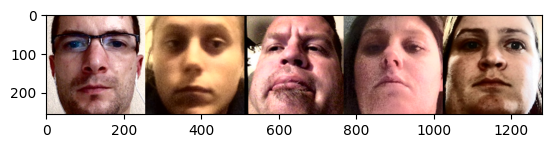

In [20]:
plt.imshow(return_image(test_batch, 1, 5, 256, 256))

Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


(-0.5, 1279.5, 255.5, -0.5)

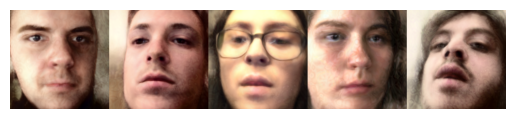

In [7]:
# load generator
import dnnlib # nvidia dnn library
import legacy # legacy support for older models
import PIL
def return_image(images, gh, gw, H, W):
    np_imgs = []
    for i, image in enumerate(images):
        image = images[i][None,:,:]
        image = (image.permute(0,2,3,1)*127.5+128).clamp(0,255).to(torch.uint8).cpu().numpy()
        np_imgs.append(np.asarray(PIL.Image.fromarray(image[0], 'RGB').resize((H,W),PIL.Image.LANCZOS)))
    np_imgs = np.stack(np_imgs)
    np_imgs = np_imgs.reshape(gh,gw,H,W,3)
    np_imgs = np_imgs.transpose(0,2,1,3,4)
    np_imgs = np_imgs.reshape(gh*H, gw*W, 3)
    #PIL.Image.fromarray(np_imgs, 'RGB').save(save_path)
    return PIL.Image.fromarray(np_imgs, 'RGB')

generator_pkl_path = "/root/data/stylegan3/inversion/stylegan3-encoder/pretrained/stylegan3-r-ffhqu-256x256.pkl"
with dnnlib.util.open_url(generator_pkl_path) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device)

G.eval()

test_img_batch_g = G.synthesis(test_latent_batch)

plt.imshow(return_image(test_img_batch_g, 1, 5, 256, 256))
plt.axis('off')



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


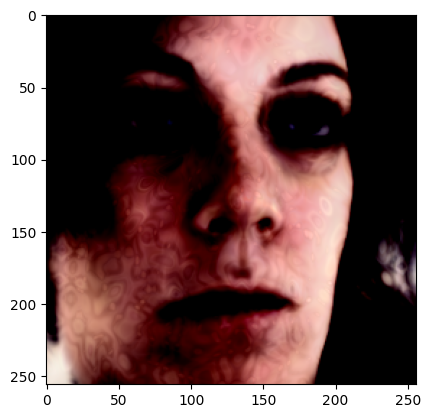

In [7]:
plt.imshow(test_img_batch_g[0].permute(1,2,0).cpu().detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


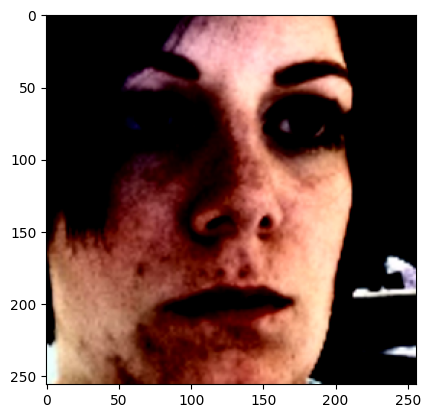

In [8]:
plt.imshow(test_batch[0].permute(1,2,0).cpu().detach().numpy())

In [12]:
test_img_batch_g[0].shape

torch.Size([3, 256, 256])

In [11]:
test_batch[0].shape

torch.Size([3, 256, 256])

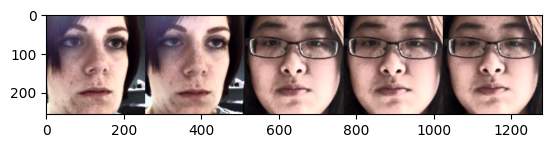

In [45]:
plt.imshow(return_image(test_batch, 1, 5, 256, 256))

(-0.5, 1279.5, 255.5, -0.5)

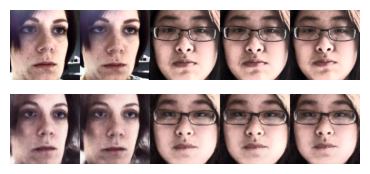

In [46]:
fig, ax = plt.subplots(2, 1, figsize=(10, 2))
ax[0].imshow(return_image(test_batch, 1, 5, 256, 256))
ax[0].axis('off')
ax[1].imshow(return_image(test_img_batch_g, 1, 5, 256, 256))
ax[1].axis('off')